In [1]:
import os
import copy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/research/impermanent_loss","")
os.chdir(cwd)

from python.dev.cpt import SolveDeltas
from python.dev.math.model import BrownianModel
from python.dev.cpt import Liquidity
from python.dev.math.model import EventSelectionModel
from python.dev.math.model import TokenDeltaModel

* https://medium.com/@chiqing/uniswap-v2-explained-beginner-friendly-b5d2cb64fe0f

In [2]:
from python.dev.simulation import SimulateLiquidity

In [3]:
N_RUNS = 1825

b = BrownianModel(0.2)
p_arr = b.gen_gbm(0.1, 1, N_RUNS, 1)

In [4]:
liq = Liquidity(10000, 2000, 'SYS','DIA')
simLiq = SimulateLiquidity(liq)
simLiq.run(p_arr)

sys_arr = simLiq.get_sys_arr()
dai_arr = simLiq.get_dai_arr()
dsys_arr  = simLiq.get_sys_deltas_arr()
ddai_arr  = simLiq.get_dai_deltas_arr()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)


In [5]:
tdel = TokenDeltaModel(100) 
liq2 = Liquidity(10000, 2000, 'SYS','DIA')
simLiq2 = SimulateLiquidity(liq2, tdel, True, True)
simLiq2.run(p_arr, dx_rate = 0.7, dy_rate = 0.55)

sys_arr2 = simLiq2.get_sys_arr()
dai_arr2 = simLiq2.get_dai_arr()
dsys_arr2  = simLiq2.get_sys_deltas_arr()
ddai_arr2  = simLiq2.get_dai_deltas_arr()

simLiq2.check(p_arr, 1000)

raw: 0.1980736 y/x: 0.1978646 dy/dx: 0.2025531 liq: 10364.9407927


In [6]:
usd_arr  = simLiq.get_usd_arr()
usd_arr2  = simLiq2.get_usd_arr()

**Initial USD investment**

In [42]:
N = 1000
dai_arr[0] + p_arr[0]*sys_arr[0]

4000.0

**HODL Value at N**

In [60]:
hodl_value = dai_arr[0] + p_arr[N]*sys_arr[0]
hodl_value

3980.73564506407

**SYS HODL value at N**

In [44]:
2*sys_arr[0]*p_arr[N]

3961.47129012814

**Total liquidity value at N**

In [68]:
dai_arr[N] + sys_arr[N]*p_arr[N]

4273.665673327365

**Pool holdings value at N**

In [46]:
dai_sys_arr = np.sqrt(dai_arr*sys_arr)
dai_sys_usd_arr = dai_sys_arr/(dai_arr + sys_arr*p_arr)
dai_sys_arr[0]/dai_sys_usd_arr[N]

3980.6890313935564

**Calculations**

In [70]:
def asset_usd(x, p):
    return x*p

def liq(x,y):
    return np.sqrt(x*y)

def lp_price(L, x_usd, y_usd):
    LUSD = x_usd + y_usd
    return L/LUSD

def hodl_value(x_init, y_init, yx_p_arr):
    return y_init + yx_p_arr*x_init

def lp_value(x, y, yx_p_arr):
    return y + x*yx_p_arr

In [48]:
dai_usd_arr = asset_usd(dai_arr, 1)
sys_usd_arr = asset_usd(sys_arr, p_arr)
lp_arr = liq(sys_arr, dai_arr)
lp_usd_arr = lp_price(lp_arr, dai_usd_arr, sys_usd_arr)
lp_usd_arr[0]

1.118033988749895

**HODL USD Value at N**

In [72]:
hodl_value(sys_arr[0], dai_arr[0], p_arr[N])

3980.73564506407

**LP USD value at N**

In [77]:
lp_value(sys_arr[N], dai_arr[N], p_arr[N])

4273.665673327365

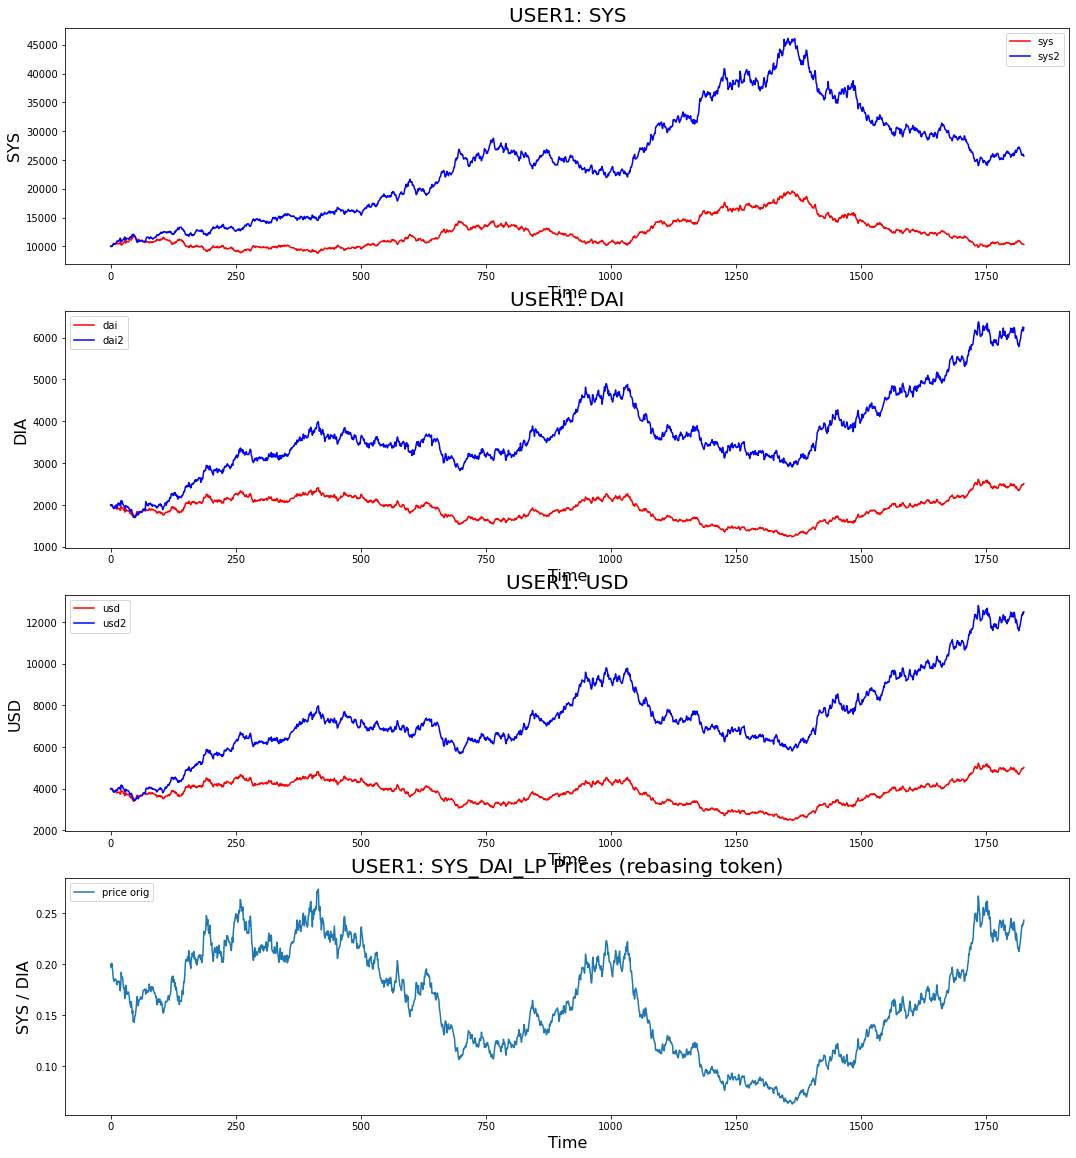

In [12]:
fig, (SYS_ax, DAI_ax, USD_ax, price_ax) = plt.subplots(nrows=4, sharex=False, sharey=False, figsize=(18, 20))
SYS_ax.plot(sys_arr, color = 'r',label='sys') 
SYS_ax.plot(sys_arr2, color = 'b',label='sys2') 
SYS_ax.set_title("USER1: SYS", fontsize=20)
SYS_ax.set_ylabel("SYS", fontsize=16)
SYS_ax.set_xlabel('Time', fontsize=16)
SYS_ax.legend()

DAI_ax.plot(dai_arr, color = 'r', label='dai') 
DAI_ax.plot(dai_arr2, color = 'b',label='dai2') 
DAI_ax.set_title("USER1: DAI", fontsize=20)
DAI_ax.set_ylabel("DIA", fontsize=16)
DAI_ax.set_xlabel('Time', fontsize=16)
DAI_ax.legend()

USD_ax.plot(usd_arr, color = 'r', label='usd') 
USD_ax.plot(usd_arr2, color = 'b',label='usd2') 
USD_ax.set_title("USER1: USD", fontsize=20)
USD_ax.set_ylabel("USD", fontsize=16)
USD_ax.set_xlabel('Time', fontsize=16)
USD_ax.legend()

price_ax.plot(p_arr, label='price orig') 
price_ax.set_title("USER1: SYS_DAI_LP Prices (rebasing token)", fontsize=20)
price_ax.set_ylabel("SYS / DIA", fontsize=16)
price_ax.set_xlabel('Time', fontsize=16)
price_ax.legend()